# Importing libraries

In [1]:
import tensorflow as tf

# Hide GPU from visible devices for tensorflow 2.3.1 and above
tf.config.set_visible_devices([], 'GPU')

import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

# Exploring dataset

In [2]:
train_dir = 'input/fer2013/train/'
test_dir = 'input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<AxesSubplot:>

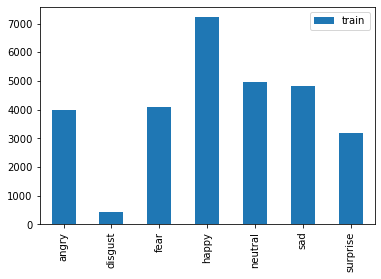

In [3]:
train_count.transpose().plot(kind='bar')

<AxesSubplot:>

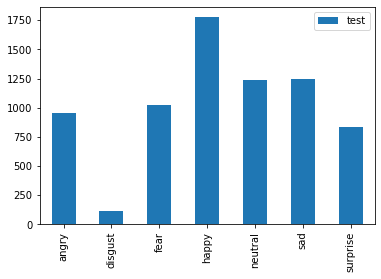

In [4]:
test_count.transpose().plot(kind='bar')

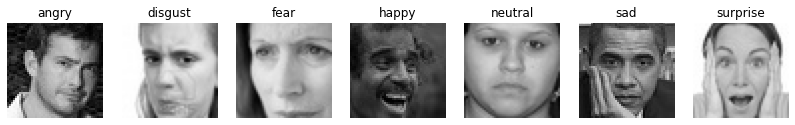

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Creating train, test, and validation dataset

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# labels 
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Model architecture

In [8]:
no_of_classes = 7

model = tf.keras.Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
# model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

model.add(Dense(no_of_classes,activation="softmax"))

opt = Adam(learning_rate = 0.0001) # lr to learning_rate
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

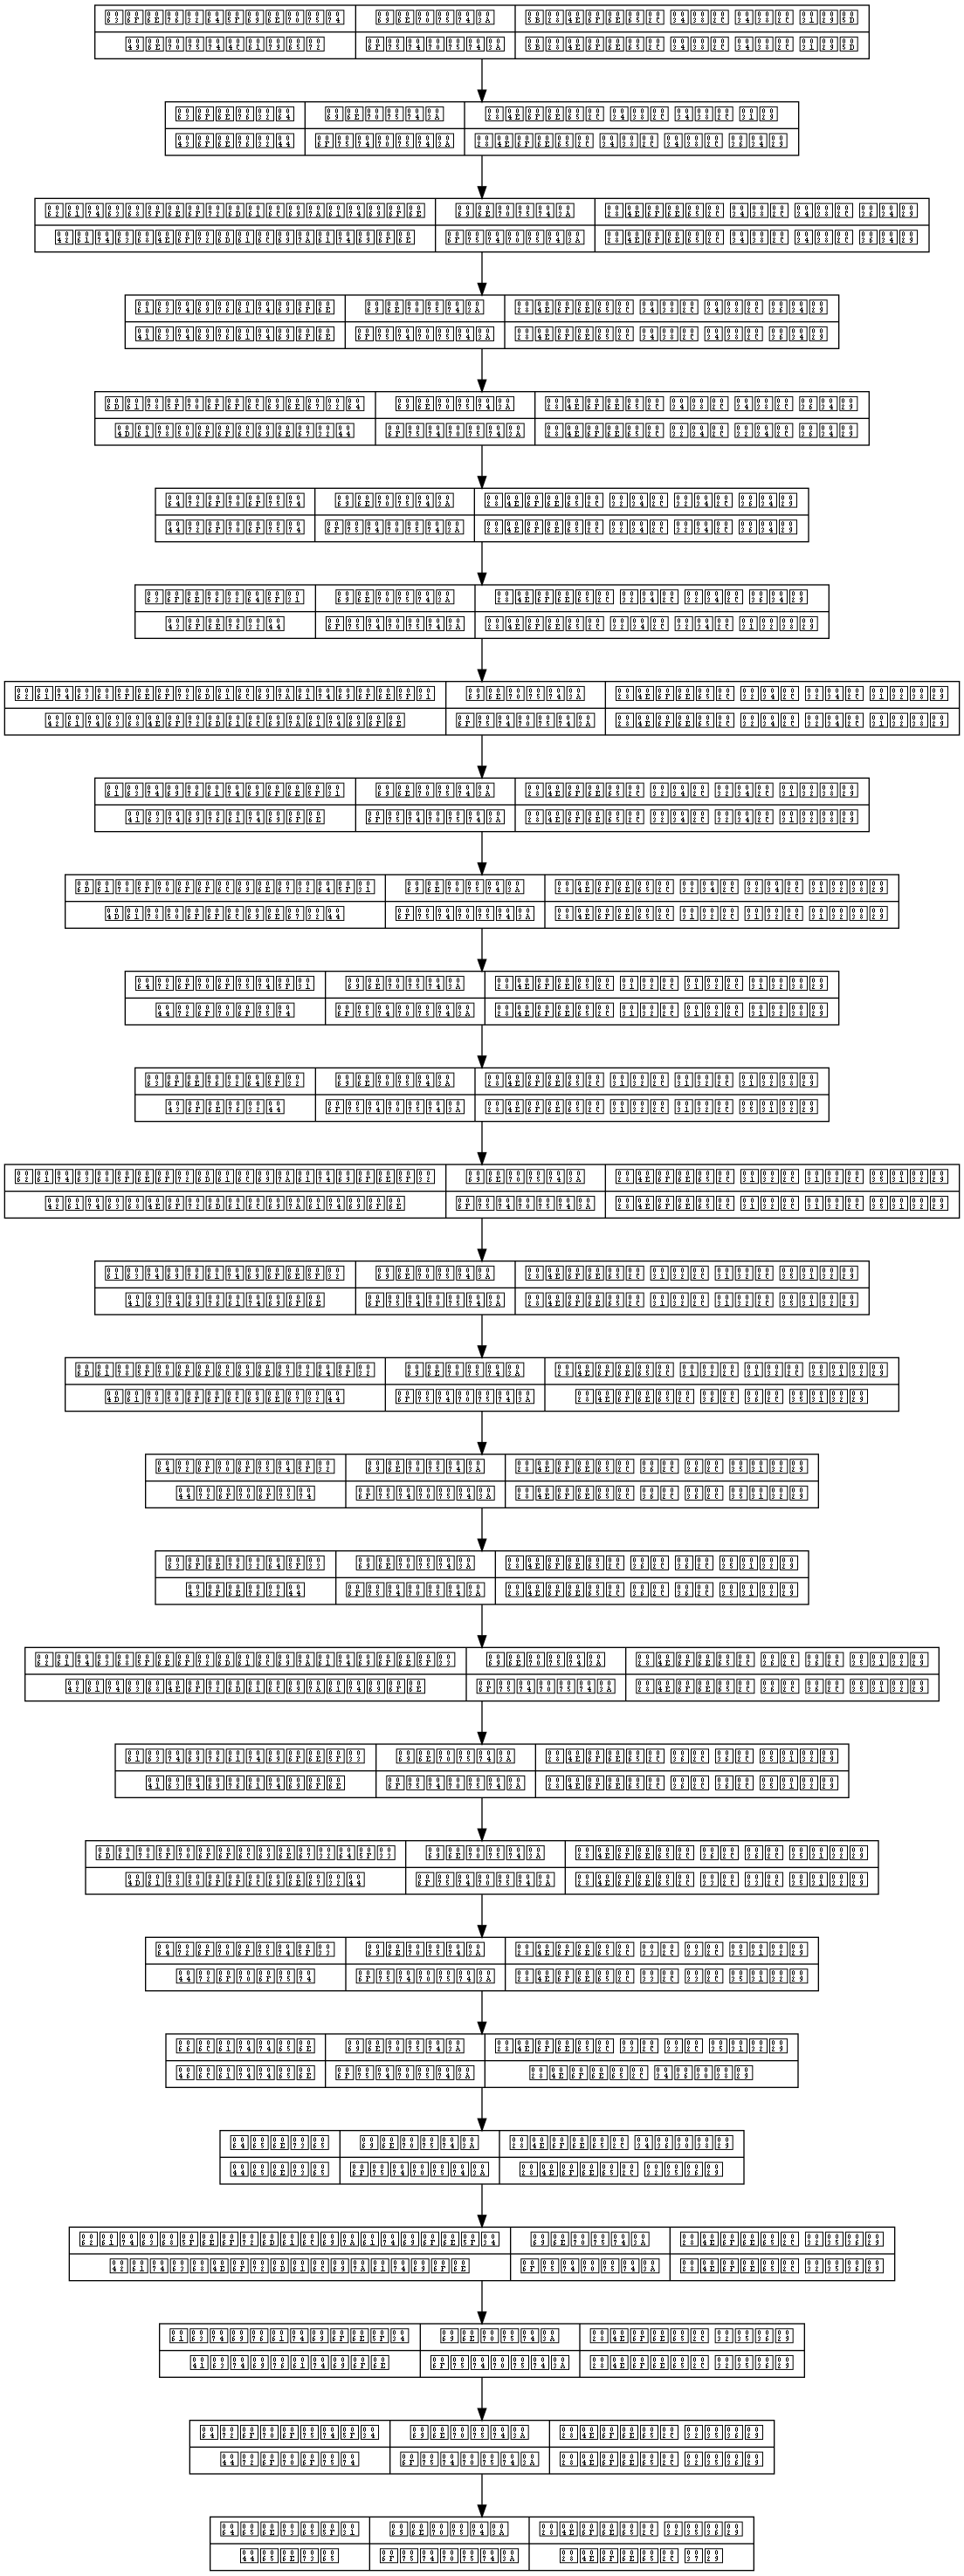

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

# Model training

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200
358/358 [==============================] - ETA: 0s - loss: 1.9903 - accuracy: 0.2568
Epoch 1: val_accuracy improved from -inf to 0.17837, saving model to model.weights.best.hdf5
358/358 [==============================] - 475s 1s/step - loss: 1.9903 - accuracy: 0.2568 - val_loss: 1.9105 - val_accuracy: 0.1784
Epoch 2/200
358/358 [==============================] - ETA: 0s - loss: 1.7454 - accuracy: 0.3307
Epoch 2: val_accuracy improved from 0.17837 to 0.33936, saving model to model.weights.best.hdf5
358/358 [==============================] - 404s 1s/step - loss: 1.7454 - accuracy: 0.3307 - val_loss: 1.7629 - val_accuracy: 0.3394
Epoch 3/200
358/358 [==============================] - ETA: 0s - loss: 1.6405 - accuracy: 0.3732
Epoch 3: val_accuracy improved from 0.33936 to 0.36306, saving model to model.weights.best.hdf5
358/358 [==============================] - 412s 1s/step - loss: 1.6405 - accuracy: 0.3732 - val_loss: 1.7156 - val_accuracy: 0.3631
Epoch 4/200
358/358 [=======

358/358 [==============================] - 425s 1s/step - loss: 0.9722 - accuracy: 0.6382 - val_loss: 1.1026 - val_accuracy: 0.5894
Epoch 27: early stopping


# Model Performance

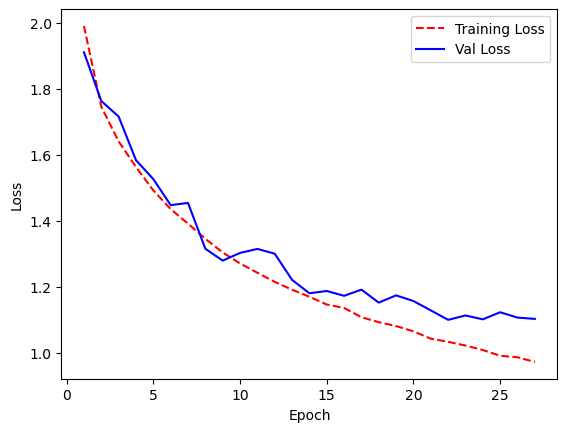

In [12]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

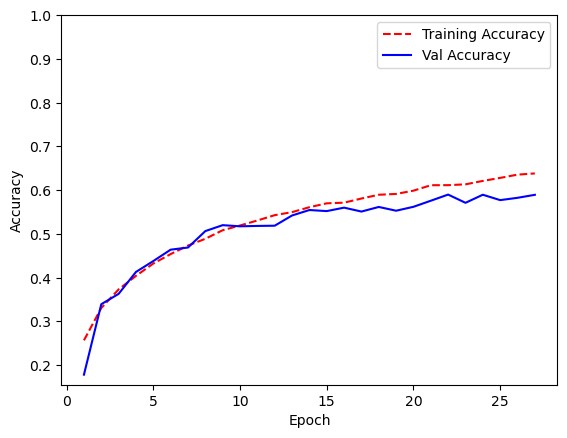

In [13]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [14]:
# saving the model
model.save("fer_model.h5")

# Test accuracy

In [15]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

112/112 [==============================] - 126s 1s/step - loss: 1.0761 - accuracy: 0.6024
Test accuracy = 60.23995280265808%


# Confusion Matrix

Confusion Martix on training sets

359/359 [==============================] - 98s 271ms/step
Confusion Matrix
[[ 460   35  241  924  580  590  366]
 [  41    3   23  104   66   66   46]
 [ 459   27  232  959  662  546  393]
 [ 860   53  405 1653 1052 1068  681]
 [ 548   42  323 1136  723  697  503]
 [ 557   43  260 1083  743  718  460]
 [ 357   21  179  799  434  458  289]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.01      0.01      0.01       349
        fear       0.14      0.07      0.09      3278
       happy       0.25      0.29      0.27      5772
     neutral       0.17      0.18      0.18      3972
         sad       0.17      0.19      0.18      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.18     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.18      0.17     22968



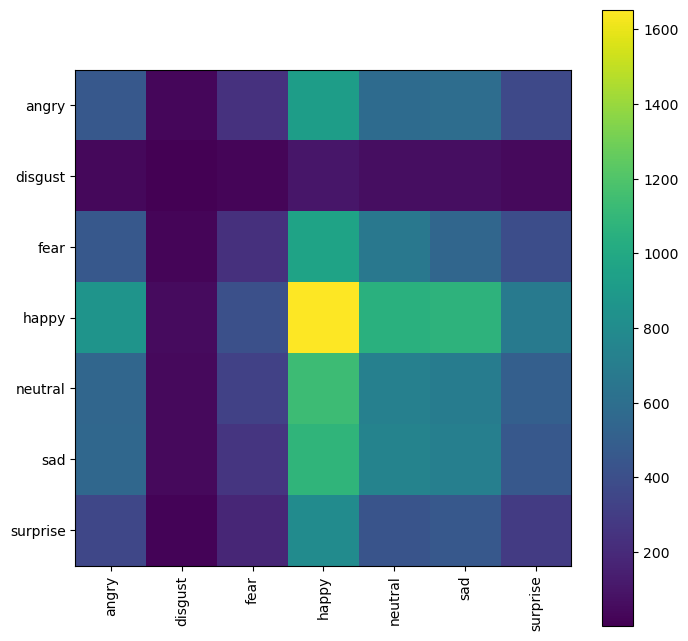

In [16]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion matrix on validation sets

90/90 [==============================] - 20s 220ms/step
Confusion Matrix
[[108   6  58 223 157 155  92]
 [ 12   0   6  22  23  12  12]
 [125   4  51 243 167 130  99]
 [222  11  89 438 277 250 156]
 [126   5  71 289 205 183 114]
 [131   8  61 286 191 164 125]
 [ 84   2  49 203 127 107  62]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       799
     disgust       0.00      0.00      0.00        87
        fear       0.13      0.06      0.08       819
       happy       0.26      0.30      0.28      1443
     neutral       0.18      0.21      0.19       993
         sad       0.16      0.17      0.17       966
    surprise       0.09      0.10      0.10       634

    accuracy                           0.18      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.18      0.17      5741



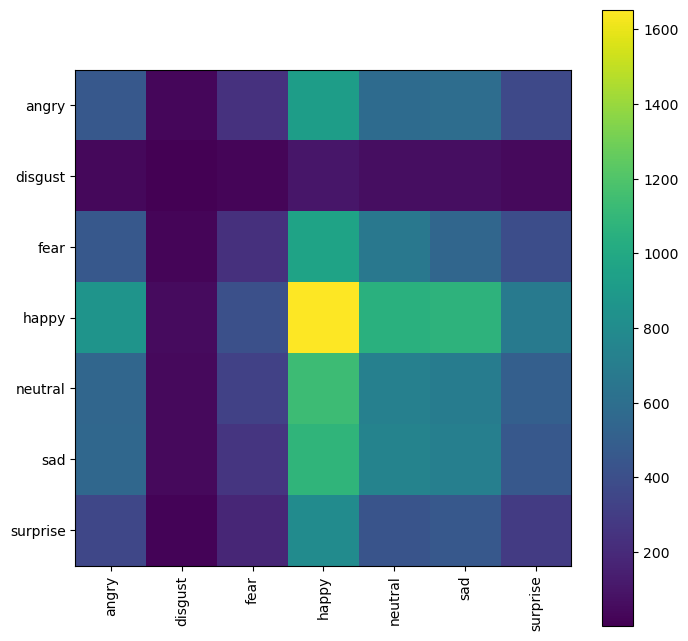

In [17]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion matrix on test sets

113/113 [==============================] - 24s 214ms/step
Confusion Matrix
[[133  16  59 255 197 179 119]
 [ 18   0   4  29  25  22  13]
 [160   3  63 277 210 172 139]
 [281  23 103 533 327 305 202]
 [163   9  78 385 223 213 162]
 [184   9  86 340 241 235 152]
 [119   7  44 265 128 155 113]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.09      1024
       happy       0.26      0.30      0.28      1774
     neutral       0.17      0.18      0.17      1233
         sad       0.18      0.19      0.19      1247
    surprise       0.13      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



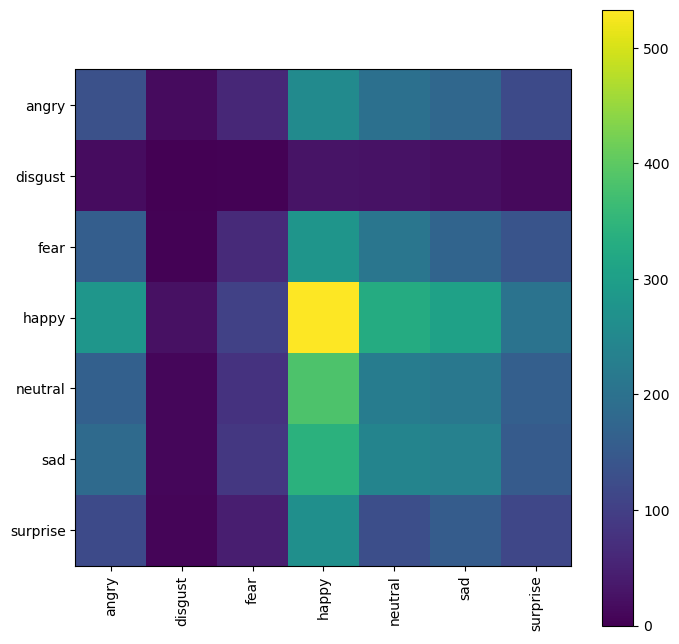

In [18]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Plotting predictions

In [19]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

2/2 [==============================] - 0s 85ms/step


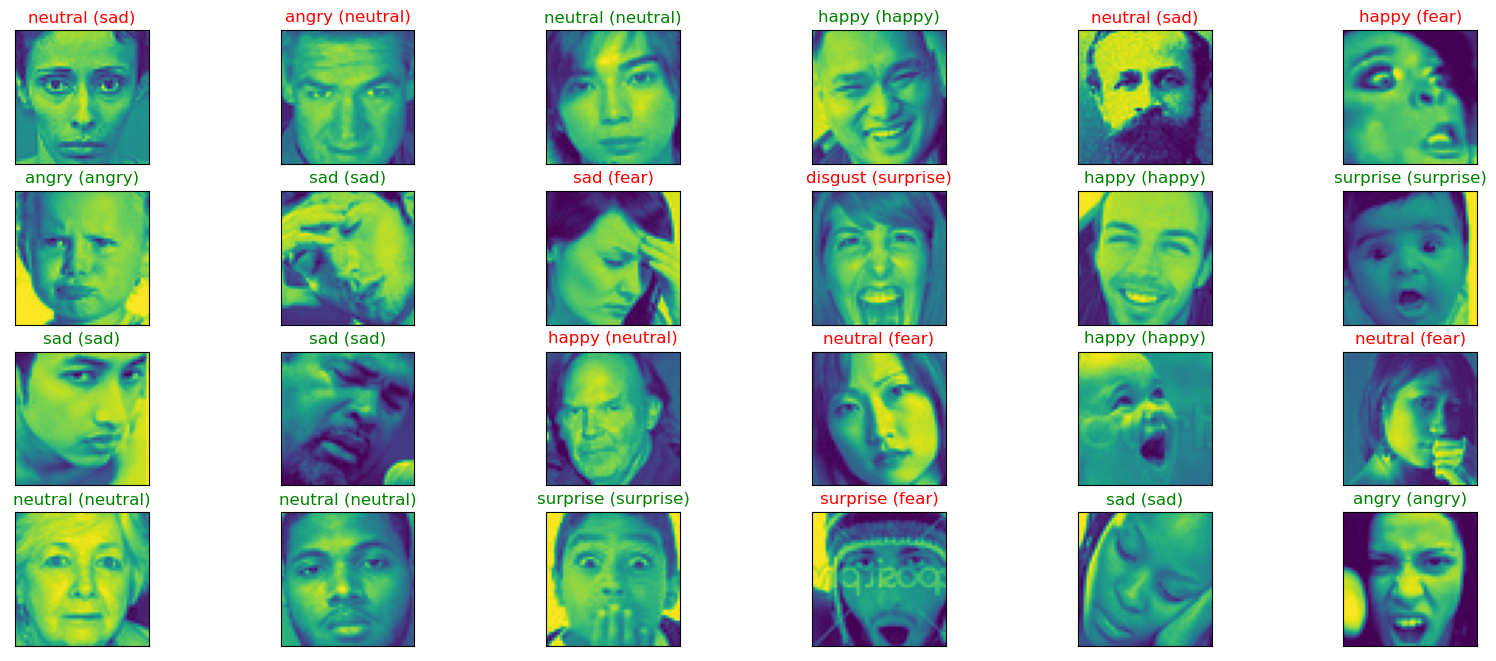

In [20]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))